<a id='main'></a>

### Data & Folders
[Data &  Folders](#data_folders)

### Scenarios covered:
[List of scenarios](#scenes)

### Functions
[functions](#functions)

### Plots:
[plots](#plots)

In [1]:
import csv
import os
os.chdir('../') # important if this notebook is not in main but in notebooks folder

import gerda.utilities.VPM_plotting as vpm_plot
import sim_parallel.get_status_data_and_plots_from_parallel as plt_para
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np

from gerda.core.virusPropagationModel import *
from gerda.utilities.VPM_plotting_parallel import *
from functools import partial

%matplotlib inline

defaultCmap = cm.get_cmap('Set2')
red_pur_Cmap = cm.get_cmap('PuRd')
reds_Cmap = cm.get_cmap('Reds')

#confi_z_dict = { 99 : 2.576, 
#                 98 : 2.326,
#                 95 : 1.96,
#                 90 : 1.645,}
#ci = z*sigma/sqrt(n)

<a id='data_folders'></a>
### Data &  Folders 
[back to top](#main)

In [3]:
server_data_folder_str = '/media/hexe/grossePlatte/job/coronaModel/simulation_results/'
scenarios_list = os.listdir(server_data_folder_str)
scenarios_list.sort()

output_folder = '/media/hexe/grossePlatte/job/coronaModel/simulation_plots/'

print(len(scenarios_list))
scenarios_list

33


['base_scenario',
 'close_all_336',
 'close_public_home_office_scan_0.2_0.9',
 'close_public_inf_0.15',
 'disobedience_scan_0.00_0.45',
 'incidence_scan_LockDownLight',
 'incidence_scan_LockDownLight_2',
 'incidence_scan_control',
 'incidence_scan_control_2',
 'infect_agents_between_age_20_24',
 'infectivity_scan_0.025_0.500',
 'infectivity_scan_0.05_0.50',
 'lockdown_start_scan_100_550',
 'mix_base_scenario',
 'mix_product_0.6',
 'modified_interaction_frequencies_Bad_Feilnbach',
 'modified_interaction_frequencies_Gangelt',
 'no_infections',
 'no_infections_mix',
 'product_0.6_scan_inf_0.075_1.200',
 'recover_from_world_scan_0.5_0.9',
 'recover_interaction_scan_0.5_0.9',
 'recover_ordered1_0.5_0.9',
 'recover_pensioner_infectivity_0.15',
 'recover_random_scan_0.5_0.9',
 'recover_random_scan_0_1',
 'recover_schedule_type',
 'reopen_all_scan_500_1500',
 'reopen_all_scan_672_1344',
 'reopen_public_scan_500_1500',
 'reopen_school_scan_500_1500',
 'reopen_work_scan_500_1500',
 'school_time_

In [3]:
inzidince_dict = { 'Gangelt': 111.9,
                   'Linsengericht': 149.1,
                   'Oranienbaum': 57.6, 
                   'Simbach': 287.2, }
inzidince_dict_rev = { 57.6: 'Oranienbaum', 
                       111.9: 'Gangelt',
                       149.1: 'Linsengericht',
                       287.2: 'Simbach', }

<a id='scenes'></a>
### List of Scenarios covered by the notebook: 
[back to top](#main)

In [4]:
## adapt scenarios list to contain NO scaned scenarios
scans_per_scene_dict = {}
for scene in scenarios_list:
    working_dir = server_data_folder_str + scene + '/'
    scans_list = os.listdir(working_dir)
    scans_list = [x for x in scans_list if '.pptx' not in x and 'plots' not in x]
    scans_per_scene_dict[scene] = scans_list

scenarios_list = [x for x in scenarios_list if len(scans_per_scene_dict[x]) == 1]

print(len(scenarios_list))
scenarios_list

8


['base_scenario',
 'close_all_336',
 'infect_agents_between_age_20_24',
 'mix_base_scenario',
 'no_infections',
 'no_infections_mix',
 'recover_pensioner_infectivity_0.15',
 'school_time_separation']

<a id='functions'></a>
### Functions 
[back to top](#main)

In [5]:
def get_df_stat(folder_scenario,server_data_folder, stat='I'):
    #assert stat in ['I','D','R','S'], stat+" not in ['I','D','R','S']"
    try:
        df_stat = pd.read_csv(server_data_folder + folder_scenario +
                         '/'+folder_scenario+'_'+stat+'.csv')
    except:
        try:
            df_stat = pd.read_csv(server_data_folder + folder_scenario +
                             '/IAR_1_0_99_'+folder_scenario[:-10]+'_'+stat+'.csv')
        except:
            print("can't read ", server_data_folder + folder_scenario +
                  '/'+folder_scenario+'_'+stat+'.csv')
    return(df_stat.drop('time', axis=1))


def dict_from_csv(filename):
    with open(filename, newline='') as file:
            reader = csv.reader(file)
            my_dict ={}
            #mydict = dict(zip([r[0] for r in reader],[r[1] for r in reader]))
            for r in reader:
                my_dict[r[0]] = r[1]
    return(my_dict)


def get_nr_of_agents(s,data_folder):
    df_ai = pd.read_csv(data_folder+s+'/IAR_1_0_99_'+s[:-9]+'agent_infos.csv')
    return(len(df_ai))


def get_lt(s,data_folder):
    df_lt = pd.read_csv(data_folder + s +
                             '/IAR_1_0_99_'+s[:-9]+'lockdown_times.csv',index_col=None)
    df_lt.drop('Unnamed: 0',axis=1, inplace=True)
    return(df_lt.mean().mean()/24)


<a id='plots'></a>
# Plots
[back to top](#main)

[base line scenario](#baseline)

[close all 336 scenario](#close336)

[close public, ki = 0.15 scenario](#closepub)

[mixing location base scenario](#mixing)

[recover (vaccination) scenarios](#recover)

<a id='baseline'></a>
### base line scenario

[back to plot overview](#plots)

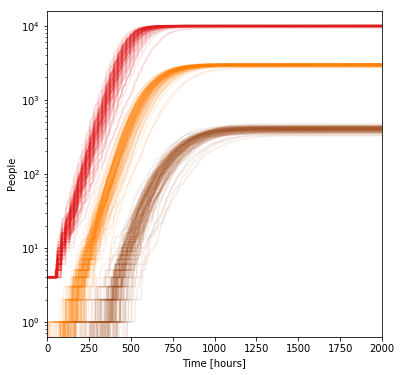

In [56]:
group_folder = 'base_scenario'
data_folder = server_data_folder_str + group_folder + '/'
subfolder_list = os.listdir(data_folder)
subfolder_list = [x for x in subfolder_list if 'plot' not in x]
subfolder = subfolder_list[0]
states_list=['cumulativ_WasInfected', 'cumulativ_WasDiagnosed', 'cumulativ_WasHospitalized', 'cumulativ_WasICUed']

fig1, axes = plt.subplots(1,1, figsize=(6,6))

plot_stat_para(axes, subfolder, data_folder, statii = states_list, log=True, prefix = 0, suffix = 10)

fig1.savefig(output_folder + "base_scenario_cumulative_flags.png")

<a id='close336'></a>
### close all 336 scenario

[back to plot overview](#plots)

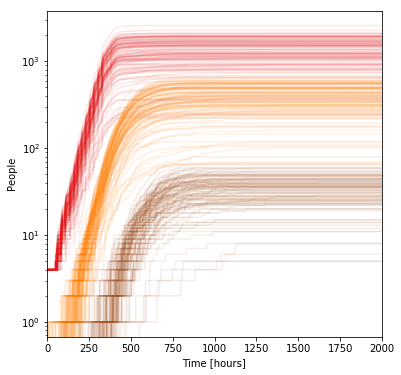

In [57]:
group_folder = 'close_all_336'
data_folder = server_data_folder_str + group_folder + '/'
subfolder_list = os.listdir(data_folder)
subfolder_list = [x for x in subfolder_list if 'plot' not in x]
subfolder = subfolder_list[0]
states_list=['cumulativ_WasInfected', 'cumulativ_WasDiagnosed', 'cumulativ_WasHospitalized', 'cumulativ_WasICUed']

fig2, axes = plt.subplots(1,1, figsize=(6,6))

plot_stat_para(axes, subfolder, data_folder, statii=states_list, log=True, prefix = 0, suffix = 10)

fig2.savefig(output_folder + "close_all_336_scenario_cumulative_flags.png")

<a id='closepub'></a>
### close public, ki = 0.15 scenario

[back to plot overview](#plots)

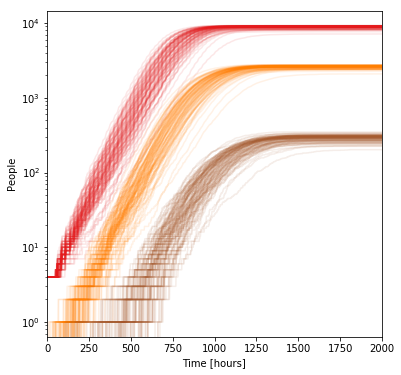

In [6]:
## only first of a scan!
group_folder = 'close_public_inf_0.15'
data_folder = server_data_folder_str + group_folder + '/'
subfolder_list = os.listdir(data_folder)
subfolder_list = [x for x in subfolder_list if 'plot' not in x]
subfolder = subfolder_list[0]
states_list=['cumulativ_WasInfected', 'cumulativ_WasDiagnosed', 'cumulativ_WasHospitalized', 'cumulativ_WasICUed']

fig3, axes = plt.subplots(1,1, figsize=(6,6))

plot_stat_para(axes, subfolder, data_folder, statii=states_list, log = True, prefix = 0, suffix = 10)

fig3.savefig(output_folder + "close_public_ki_0.15_scenario_cumulative_flags.png")

<a id='mixing'></a>
### mixing location base scenario

[back to plot overview](#plots)

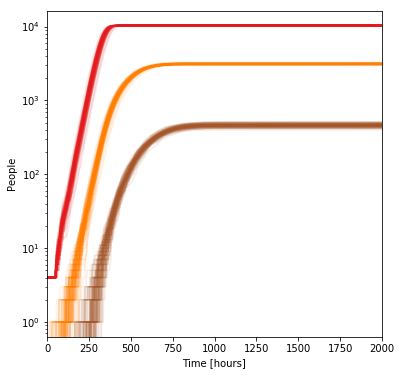

In [55]:
group_folder = 'mix_base_scenario'
data_folder = server_data_folder_str + group_folder + '/'
subfolder_list = os.listdir(data_folder)
subfolder_list = [x for x in subfolder_list if 'plot' not in x]
subfolder = subfolder_list[0]
states_list=['cumulativ_WasInfected', 'cumulativ_WasDiagnosed', 'cumulativ_WasHospitalized', 'cumulativ_WasICUed']

fig4, axes = plt.subplots(1,1, figsize=(6,6))

plot_stat_para(axes, subfolder, data_folder, statii=states_list, log=True, prefix = 0, suffix = 10)

fig4.savefig(output_folder + "mix_base_scenario_cumulative_flags.png")

<a id='recover'></a>
### recover (vaccionation) scenarios

[back to plot overview](#plots)

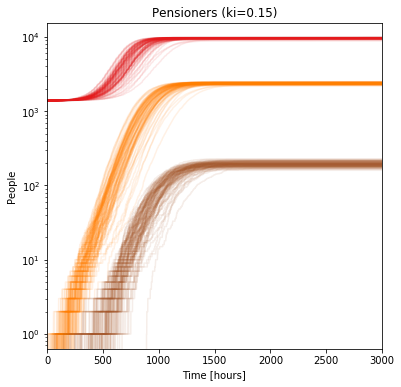

In [54]:
group_folder = 'recover_pensioner_infectivity_0.15'
data_folder = server_data_folder_str + group_folder + '/'
subfolder_list = os.listdir(data_folder)
subfolder_list = [x for x in subfolder_list if 'plot' not in x]
subfolder = subfolder_list[0]
states_list=['cumulativ_WasInfected', 'cumulativ_WasDiagnosed', 'cumulativ_WasHospitalized', 'cumulativ_WasICUed']

fig5, axes = plt.subplots(1,1, figsize=(6,6))

plot_stat_para(axes, subfolder, data_folder, statii=states_list, log=True, prefix = 0, suffix = 10)
axes.set_title('Pensioners (ki=0.15)')

fig5.savefig(output_folder + "recover_pensioner_ki_0.15_scenario_cumulative_flags.png")

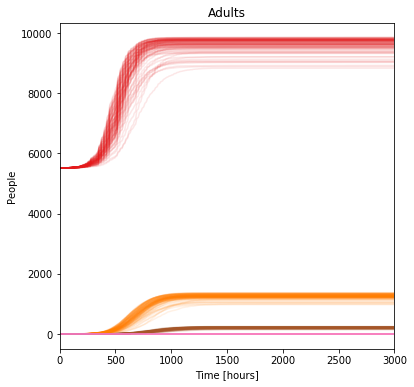

In [49]:
group_folder = 'recover_schedule_type' ## adult
data_folder = server_data_folder_str + group_folder + '/'
subfolder_list = os.listdir(data_folder)
subfolder_list = [x for x in subfolder_list if 'plot' not in x]
subfolder = subfolder_list[0]
states_list=['cumulativ_WasInfected', 'cumulativ_WasDiagnosed', 'cumulativ_WasHospitalized', 'cumulativ_WasICUed']

fig6, axes = plt.subplots(1,1, figsize=(6,6))

plot_stat_para(axes, subfolder, data_folder, statii=states_list, prefix = 0, suffix = 10)
axes.set_title('Adults')

fig6.savefig(output_folder + "recover_adults_scenario_cumulative_flags.png")

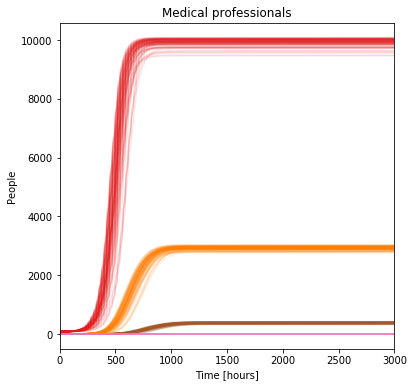

In [50]:
group_folder = 'recover_schedule_type' ## medical professionals
data_folder = server_data_folder_str + group_folder + '/'
subfolder_list = os.listdir(data_folder)
subfolder_list = [x for x in subfolder_list if 'plot' not in x]
subfolder = subfolder_list[1]
states_list=['cumulativ_WasInfected', 'cumulativ_WasDiagnosed', 'cumulativ_WasHospitalized', 'cumulativ_WasICUed']


fig7, axes = plt.subplots(1,1, figsize=(6,6))

plot_stat_para(axes, subfolder, data_folder, statii=states_list, prefix = 0, suffix = 10)
axes.set_title('Medical professionals')

fig7.savefig(output_folder + "recover_medical_professional_scenario_cumulative_flags.png")

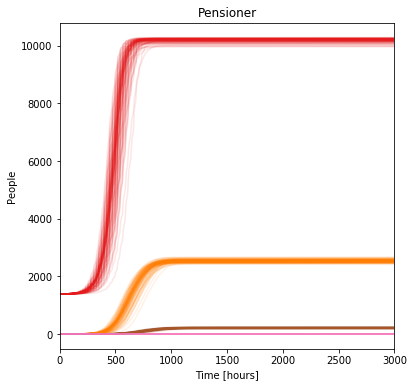

In [51]:
group_folder = 'recover_schedule_type' ## pensioner
data_folder = server_data_folder_str + group_folder + '/'
subfolder_list = os.listdir(data_folder)
subfolder_list = [x for x in subfolder_list if 'plot' not in x]
subfolder = subfolder_list[2]
states_list=['cumulativ_WasInfected', 'cumulativ_WasDiagnosed', 'cumulativ_WasHospitalized', 'cumulativ_WasICUed']


fig8, axes = plt.subplots(1,1, figsize=(6,6))

plot_stat_para(axes, subfolder, data_folder, statii=states_list, prefix = 0, suffix = 10)
axes.set_title('Pensioner')

fig8.savefig(output_folder + "recover_pensioner_scenario_cumulative_flags.png")

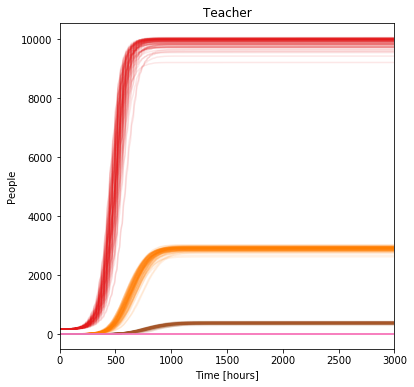

In [52]:
group_folder = 'recover_schedule_type' ## teacher
data_folder = server_data_folder_str + group_folder + '/'
subfolder_list = os.listdir(data_folder)
subfolder_list = [x for x in subfolder_list if 'plot' not in x]
subfolder = subfolder_list[3]
states_list=['cumulativ_WasInfected', 'cumulativ_WasDiagnosed', 'cumulativ_WasHospitalized', 'cumulativ_WasICUed']

fig9, axes = plt.subplots(1,1, figsize=(6,6))

plot_stat_para(axes, subfolder, data_folder, statii=states_list, prefix = 0, suffix = 10)
axes.set_title('Teacher')

fig9.savefig(output_folder + "recover_teacher_scenario_cumulative_flags.png")

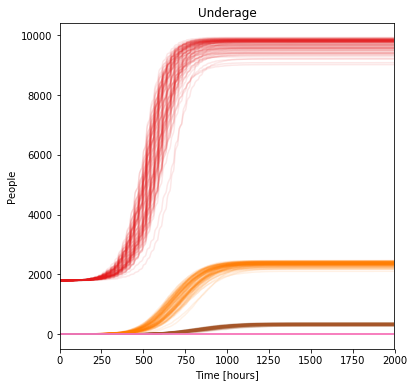

In [53]:
group_folder = 'recover_schedule_type' ## underage
data_folder = server_data_folder_str + group_folder + '/'
subfolder_list = os.listdir(data_folder)
subfolder_list = [x for x in subfolder_list if 'plot' not in x]
subfolder = subfolder_list[4]
states_list=['cumulativ_WasInfected', 'cumulativ_WasDiagnosed', 'cumulativ_WasHospitalized', 'cumulativ_WasICUed']

fig10, axes = plt.subplots(1,1, figsize=(6,6))

plot_stat_para(axes, subfolder, data_folder, statii=states_list, prefix = 0, suffix = 10)
axes.set_title('Underage')

fig10.savefig(output_folder + 'recover_underage_scenario_cumulative_flags.png')

## combined


In [8]:
#group_folder_c = 'incidence_scan_control'
#group_folder_ldl = 'incidence_scan_LockDownLight'
group_folders_ldl = ['incidence_scan_control','incidence_scan_LockDownLight']
group_folders_ldl_2 = ['incidence_scan_LockDownLight_2']

<a id='infection'></a>
#### infection 
[back to top](#main)

0.3827546818966662 Oranienbaum
0.3530364216017776 Gangelt
0.3644527704485488 Linsengericht
0.39316258351893096 Simbach


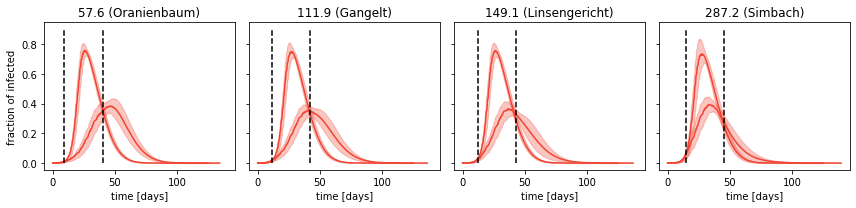

In [9]:
r1=reds_Cmap(0.6)
r2=reds_Cmap(1)
max_times = []

group_folder = 'incidence_scan_control'

fig, axes = plt.subplots(1,4, figsize=(12,3), sharey=True, sharex=True)
ax_series = axes.flatten()

for group_folder in group_folders_ldl:
    
    data_folder = server_data_folder_str+group_folder +'/'
    subfolder = os.listdir(data_folder)
    subfolder.sort(reverse=True)
    
    for k,incidence in enumerate(inzidince_dict_rev):
        town = inzidince_dict_rev[incidence]
        s = [s for s in subfolder if s.startswith(inzidince_dict_rev[incidence])][0]
        #data
        nr_of_agents = get_nr_of_agents(s,data_folder)
        sim_para_dict = dict_from_csv(data_folder+s+'/sim_parameters.csv')
        lockdown_times = [int(sim_para_dict['start_2']), int(sim_para_dict['start_3'])]
        
        df_I = get_df_stat(s, data_folder,stat='I')
        df_I_m = df_I.mean(axis=1)/nr_of_agents
        df_I_std = df_I.std(axis=1)/nr_of_agents
        CI = confi_z_dict[99]*df_I_std.values/np.sqrt(len(df_I.columns))

        #plot
        ax_series[k].plot(df_I_m.index/24,df_I_m.values, color=r1)
        #ax_series[k].fill_between(df_I_m.index,df_I_m.values-CI,df_I_m.values+CI, color=r1, alpha=0.3)
        ax_series[k].fill_between(df_I_m.index/24,df_I_m.values-df_I_std,df_I_m.values+df_I_std, color=r1, alpha=0.3)
        
        if group_folder.split('_')[-1]!='control':
            for time in lockdown_times:
                ax_series[k].plot([time/24]*10,np.arange(0,1,0.1),'--k')
            print(df_I_m.max(), town)
            
            t_max = df_I_m[df_I_m==df_I_m.max()].index[0]
            max_times.append({'incidence':incidence,
                              'mean':df_I.idxmax().mean(),
                              'std':df_I.idxmax().std(),
                              'CI':confi_z_dict[95]*df_I.idxmax().std()/10,
                              'lockdown_start': lockdown_times[0],
                              'lockdown_end': lockdown_times[1], })
                             
        ax_series[k].set_title('{0} ({1})'.format(incidence,town))
        ax_series[k].set_xlabel('time [days]')
        
ax_series[0].set_ylabel('fraction of infected')

plt.tight_layout() 

max_times_df = pd.DataFrame(max_times)

Text(0, 0.5, 'max time [days] ')

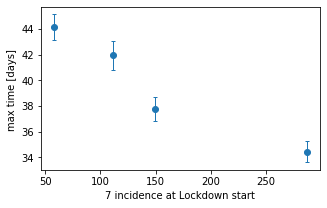

In [10]:
fig, ax = plt.subplots(1,1, figsize=(5,3))
ax.errorbar(x=max_times_df['incidence'],
             y=(max_times_df['mean'])/24,
             yerr=max_times_df['CI']/24,
             fmt='o',
             elinewidth=1,
             barsabove=True,
             capsize=2, )#CI 95
ax.set_xlabel('7 incidence at Lockdown start')
ax.set_ylabel('max time [days] ')

<a id='lockdownL_2'></a>
### Lockdown light 2
with: home office 20%, reduced school acitivies (schedule based) If0.15 and lockdown at Incidence 

[back to top](#main)

In [10]:
def get_lt(s,data_folder):
    df_lt = pd.read_csv(data_folder + s +
                             '/IAR_1_0_99_'+s[:-9]+'lockdown_times.csv',index_col=None)
    df_lt.drop('Unnamed: 0',axis=1, inplace=True)
    return(df_lt.mean().mean()/24)

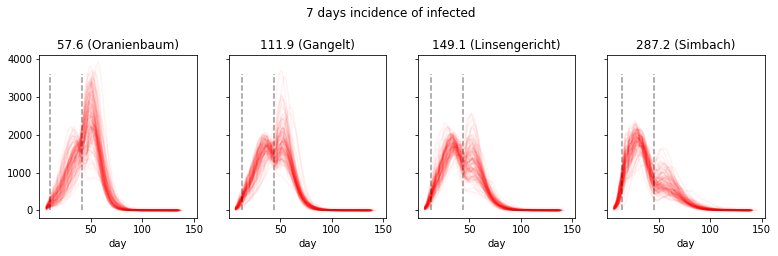

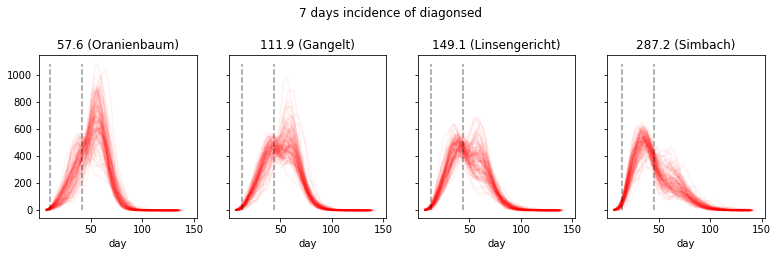

In [159]:
max_values = [4000,1200]
titles = ['7 days incidence of infected','7 days incidence of diagonsed']

for i,stat in enumerate(['cumulativ_Wasinfected','cumulativ_WasDiagnosed']):
    fig, axes = plt.subplots(1,4, figsize=(13,3), sharey=True, sharex=True)
    ax_series = axes.flatten()
    plt.suptitle(titles[i], y=1.1)
    
    for k,incidence in enumerate(inzidince_dict_rev):
        town = inzidince_dict_rev[incidence]
        s = [s for s in subfolder if s.startswith(inzidince_dict_rev[incidence])][0]
        nr_of_agents = get_nr_of_agents(s,data_folder)

        df_total_diag = get_df_stat(s, data_folder, stat=stat)#cumulativ_WasDiagnosed
        df_total_diag['day'] = [int(x/24) for x in df_total_diag.index]
        df_diag_day = df_total_diag.groupby('day').max()
        df_diff = df_diag_day.diff()/nr_of_agents*100000
        #df_diff.plot(color='r', alpha=0.01,legend=False, ax=ax_series[k],title='{0} ({1})'.format(incidence,town))
        df_diff_sw = df_diff.rolling(7).sum()/7
        df_diff_sw.plot(color='r', alpha=0.05,legend=False,
                        ax=ax_series[k],title='{0} ({1})'.format(incidence,town))
        df_above_inci=df_diff_sw>=incidence
        t_start = get_lt(s,data_folder)
        t_ende =  t_start + 31
        lockdown_times = [int(sim_para_dict['start_2']), int(sim_para_dict['start_3'])]
                    
        ax_series[k].plot([t_start]*10,np.arange(0,max_values[i],max_values[i]/10),'--k', alpha=0.4)
        ax_series[k].plot([t_ende]*10,np.arange(0,max_values[i],max_values[i]/10),'--k', alpha=0.4)
#

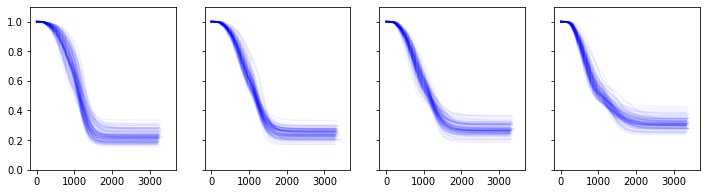

In [169]:
fig, axes = plt.subplots(1,4, figsize=(12,3), sharey=True, sharex=True)
ax_series = axes.flatten()

for k,incidence in enumerate(inzidince_dict_rev):
    town = inzidince_dict_rev[incidence]
    s = [s for s in subfolder if s.startswith(inzidince_dict_rev[incidence])][0]
    nr_of_agents = get_nr_of_agents(s,data_folder)
    df_S = get_df_stat(s,data_folder,'S')/nr_of_agents
    df_S.plot(color='b',legend=False,alpha=0.05, ax=ax_series[k])
    ax_series[k].set_ylim(0.0,1.1)

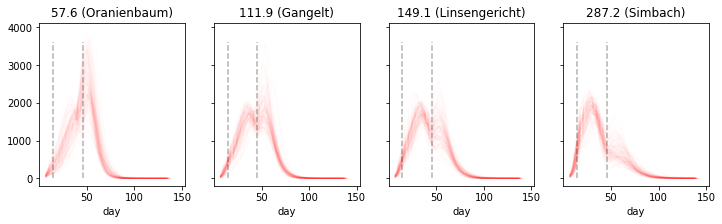

In [80]:
fig, axes = plt.subplots(1,4, figsize=(12,3), sharey=True, sharex=True)
ax_series = axes.flatten()

for k,incidence in enumerate(inzidince_dict_rev):
    town = inzidince_dict_rev[incidence]
    s = [s for s in subfolder if s.startswith(inzidince_dict_rev[incidence])][0]
    nr_of_agents = get_nr_of_agents(s,data_folder)
    
    df_total_diag = get_df_stat(s, data_folder, stat='cumulativ_WasInfected')#cumulativ_WasDiagnosed
    df_total_diag['day'] = [int(x/24) for x in df_total_diag.index]
    df_diag_day = df_total_diag.groupby('day').max()
    df_diff = df_diag_day.diff(periods=1)/nr_of_agents*100000
    #df_diff.plot(color='r', alpha=0.01,legend=False, ax=ax_series[k],title='{0} ({1})'.format(incidence,town))
    df_diff_sw = df_diff.rolling(7).sum()/7
    df_diff_sw.plot(color='r', alpha=0.01,legend=False, ax=ax_series[k],title='{0} ({1})'.format(incidence,town))
    lockdown_times = [int(sim_para_dict['start_2']), int(sim_para_dict['start_3'])]
    
    for time in lockdown_times:
        ax_series[k].plot([time/24]*10,np.arange(0,4000,400),'--k', alpha=0.3)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


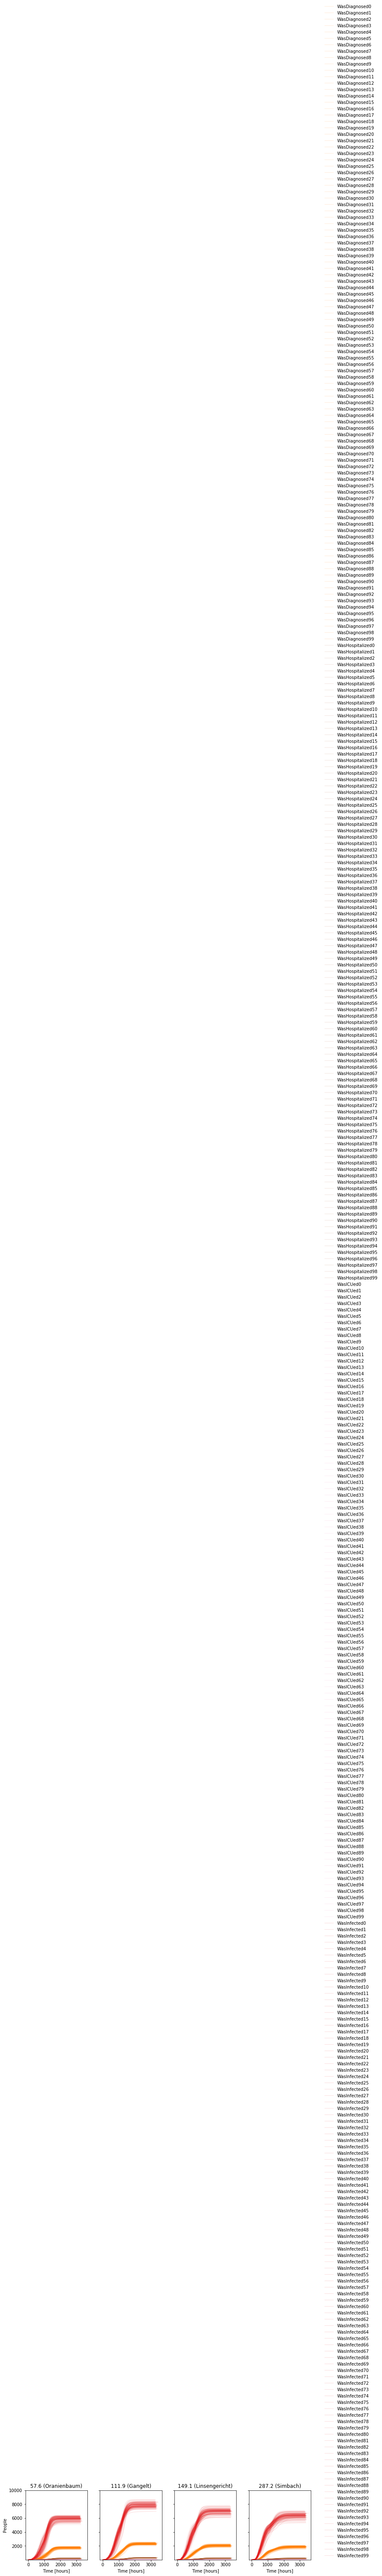

In [14]:
group_folder = 'incidence_scan_LockDownLight_2'
data_folder = server_data_folder_str+group_folder +'/'
subfolder = os.listdir(data_folder)
statii= ['WasDiagnosed', 'WasHospitalized', 'WasICUed', 'WasInfected' ]
statii_extend = ['cumulativ_'+x for x in statii]

fig, axes = plt.subplots(1,4, figsize=(12,3), sharey=True, sharex=True)
ax_series = axes.flatten()

for k,incidence in enumerate(inzidince_dict_rev):
    town = inzidince_dict_rev[incidence]
    s = [s for s in subfolder if s.startswith(inzidince_dict_rev[incidence])][0]
    nr_of_agents = get_nr_of_agents(s,data_folder)
    #plot
    plot_stat_para(ax_series[k], s, data_folder, statii=statii_extend, log=False)
    ax_series[k].set_title('{0} ({1})'.format(incidence,town))
    ax_series[k].set_ylim(1,10000)
    if k>0:
        ax_series[k].set_ylabel('')
#ax_series[-1].legend(frameon=False, loc=(1.2,0.))
plt.tight_layout()  

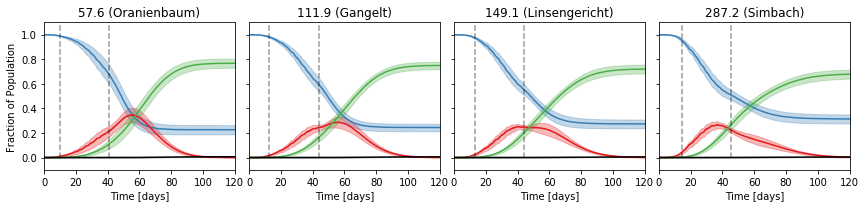

In [19]:
group_folder = 'incidence_scan_LockDownLight_2'
data_folder = server_data_folder_str+group_folder +'/'
subfolder = os.listdir(data_folder)

fig, axes = plt.subplots(1,4, figsize=(12,3), sharey=True, sharex=True)
ax_series = axes.flatten()

for k,incidence in enumerate(inzidince_dict_rev):
    town = inzidince_dict_rev[incidence]
    s = [s for s in subfolder if s.startswith(inzidince_dict_rev[incidence])][0]
    nr_of_agents = get_nr_of_agents(s,data_folder)
    #plot
    plot_stat_para_mean_error(ax_series[k], s, data_folder, error_type='std',
                              nr_of_agents=nr_of_agents, per_day=True)
    ax_series[k].set_title('{0} ({1})'.format(incidence,town))
    
    #lockdown marker
    t_start = get_lt(s,data_folder)
    t_ende =  t_start + 31
    
    ax_series[k].plot([t_start]*10, np.linspace(0,1.1,10),'--k', alpha=0.4)
    ax_series[k].plot([t_ende]*10, np.linspace(0,1.1,10),'--k', alpha=0.4)
    
    if k>0:
        ax_series[k].set_ylabel('')
    ax_series[0].set_ylabel('Fraction of Population')
    ax_series[k].set_xlim(0,120)
    ax_series[k].set_ylim(-0.1,1.1)
    ax_series[k].set_xlabel('Time [days]')
plt.tight_layout() 

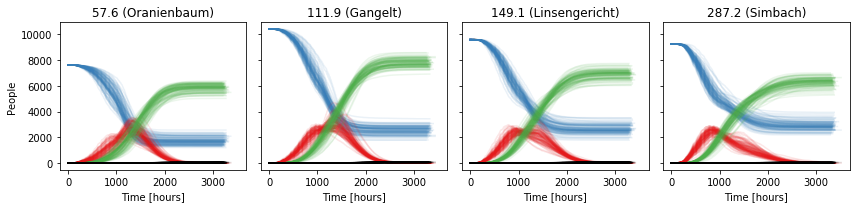

In [12]:
group_folder = 'incidence_scan_LockDownLight_2'
data_folder = server_data_folder_str+group_folder +'/'
subfolder = os.listdir(data_folder)

fig, axes = plt.subplots(1,4, figsize=(12,3), sharey=True, sharex=True)
ax_series = axes.flatten()


for k,incidence in enumerate(inzidince_dict_rev):
    town = inzidince_dict_rev[incidence]
    s = [s for s in subfolder if s.startswith(inzidince_dict_rev[incidence])][0]
    #plot
    plot_stat_para(ax_series[k], s, data_folder)
    ax_series[k].set_title('{0} ({1})'.format(incidence,town))
plt.tight_layout()    

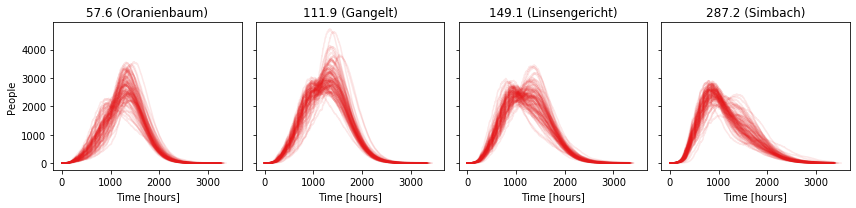

In [48]:
group_folder = 'incidence_scan_LockDownLight_2'
data_folder = server_data_folder_str+group_folder +'/'
subfolder = os.listdir(data_folder)

fig, axes = plt.subplots(1,4, figsize=(12,3), sharey=True, sharex=True)
ax_series = axes.flatten()


for k,incidence in enumerate(inzidince_dict_rev):
    town = inzidince_dict_rev[incidence]
    s = [s for s in subfolder if s.startswith(inzidince_dict_rev[incidence])][0]
    #plot
    plot_stat_para(ax_series[k], s, data_folder, statii=['I'])
    ax_series[k].set_title('{0} ({1})'.format(incidence,town))
plt.tight_layout()    

0.3465643849986887 Oranienbaum
0.2877956008068389 Gangelt
0.251824246846659 Linsengericht
0.26695699157121244 Simbach


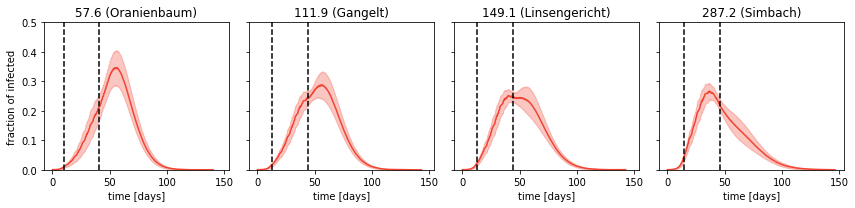

In [14]:
r1=reds_Cmap(0.6)
r2=reds_Cmap(1)
max_times = []



fig, axes = plt.subplots(1,4, figsize=(12,3), sharey=True, sharex=True)
ax_series = axes.flatten()

for group_folder in group_folders_ldl_2:
    
    data_folder = server_data_folder_str+group_folder +'/'
    subfolder = os.listdir(data_folder)
    subfolder.sort(reverse=True)
    
    for k,incidence in enumerate(inzidince_dict_rev):
        town = inzidince_dict_rev[incidence]
        s = [s for s in subfolder if s.startswith(inzidince_dict_rev[incidence])][0]
        #data
        nr_of_agents = get_nr_of_agents(s,data_folder)
        sim_para_dict = dict_from_csv(data_folder+s+'/sim_parameters.csv')
        t_start = get_lt(s,data_folder)
        t_ende =  t_start + 31
        #lockdown_times = [int(sim_para_dict['start_2']), int(sim_para_dict['start_3'])]
                    
        #ax_series[k].plot([t_start]*10,np.arange(0,max_values[i],max_values[i]/10),'--k', alpha=0.4)
        
        df_I = get_df_stat(s, data_folder,stat='I')
        df_I_m = df_I.mean(axis=1)/nr_of_agents
        df_I_std = df_I.std(axis=1)/nr_of_agents
        CI = confi_z_dict[99]*df_I_std.values/np.sqrt(len(df_I.columns))

        #plot
        ax_series[k].plot(df_I_m.index/24,df_I_m.values, color=r1)
        #ax_series[k].fill_between(df_I_m.index,df_I_m.values-CI,df_I_m.values+CI, color=r1, alpha=0.3)
        ax_series[k].fill_between(df_I_m.index/24,df_I_m.values-df_I_std,df_I_m.values+df_I_std, color=r1, alpha=0.3)
        
        if group_folder.split('_')[-1]!='control':
            
            ax_series[k].plot([t_start]*10,np.arange(0,1,0.1),'--k')
            ax_series[k].plot([t_ende]*10,np.arange(0,1,0.1),'--k')
            print(df_I_m.max(), town)
            
            t_max = df_I_m[df_I_m==df_I_m.max()].index[0]
            max_times.append({'incidence':incidence,
                              'mean':df_I.idxmax().mean(),
                              'std':df_I.idxmax().std(),
                              'CI':confi_z_dict[95]*df_I.idxmax().std()/10,
                              'lockdown_start': t_start,
                              'lockdown_end': t_ende, })
                             
        ax_series[k].set_title('{0} ({1})'.format(incidence,town))
        ax_series[k].set_xlabel('time [days]')
        ax_series[k].set_ylim(0.0,0.5)
        
ax_series[0].set_ylabel('fraction of infected')

plt.tight_layout() 

max_times_df = pd.DataFrame(max_times)

In [95]:
from scipy.optimize import curve_fit

def gaussian(x, p): #mu1, mu2, sig1, sig2,A1,A2):
    mu = p[0],
    mu2 = p[1], 
    sig1 = p[2],
    sig2 = p[3],
    A1 = p[4],
    A2 = p[5]
    return A1*np.exp(-np.power(x - mu1, 2.) / (2 * np.power(sig1, 2.)))+A2*np.exp(-np.power(x - mu2, 2.) / (2 * np.power(sig2, 2.)))

In [96]:
def gaussian(x, mu1, mu2, sig1, sig2,A1,A2):
    return A1*np.exp(-np.power(x - mu1, 2.) / (2 * np.power(sig1, 2.)))+A2*np.exp(-np.power(x - mu2, 2.) / (2 * np.power(sig2, 2.)))

SyntaxError: can't use starred expression here (<ipython-input-102-b76a9b0a46ee>, line 4)

[1.24746196e+03 3.73405975e+02 5.27070604e+02 6.50181789e-03
 2.14741727e+03 3.03919479e-02]


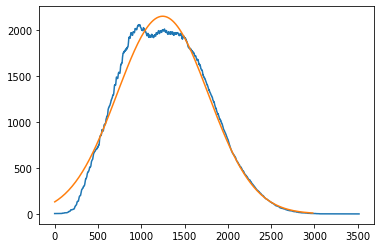

In [116]:
x = np.arange(1,3000,20)
p = [20*24,10*24, 30*24,10*24,800,700]
#plt.plot(x, gaussian(x,20*24,10*24, 30*24,10*24,800,700))

df_I['I3']
df = df_I['I3'].fillna(value=0)
bounds =([200,200,0,0,0,0],[2000,2000,3000,3000,8000,8000])
#bounds = [(500,2000),(500,2000),(100,1000),(100,1000),(0,8000),(0,8000)]
popt, pcov = curve_fit(gaussian, df.index, df.values,p0=[20*24,10*24, 40*24,10*24,2000,2000], bounds=bounds)
plt.plot(df.index, df.values)
plt.plot(x, gaussian(x,*popt))
print(popt)